# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

# pip install pandas_market_calendars
import pandas_market_calendars as mcal
# pip install python-dateutil
from dateutil.relativedelta import relativedelta
from datetime import timedelta 

import json
import datetime

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $62438.40
The current value of your 5.3 ETH is $10268.11


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
base_url = 'https://paper-api.alpaca.markets'

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key, 
    base_url,
    api_version="v2")

In [8]:
# Format current date as ISO format
# Get the latest closing day as of Today()
nyse = mcal.get_calendar('NYSE')
timezone = nyse.tz.zone

# Define a virtual calendar we want to check for the latest trading day
start_date = datetime.datetime.today() - datetime.timedelta(days=7)
end_date = datetime.datetime.today()

# Get the most recent trading day based on virutal calendar and official trading calendar
trading_end_date_raw = max(nyse.valid_days(start_date=start_date, end_date=end_date).date)
trading_end_date = pd.Timestamp(trading_end_date_raw, tz=timezone).isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_stocks_bonds = alpaca.get_barset(
    tickers,
    timeframe,
    start = trading_end_date,
    end = trading_end_date
).df

# Preview DataFrame
df_stocks_bonds

AGG                                        SPY  \
                             open    high     low     close   volume    open   
time                                                                           
2021-02-18 00:00:00-05:00  116.14  116.28  116.03  116.2178  3711844  389.59   

                                                               
                              high     low    close    volume  
time                                                           
2021-02-18 00:00:00-05:00  391.515  387.74  391.295  45188122

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(df_stocks_bonds["AGG"]["close"])
spy_close_price = float(df_stocks_bonds["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $116.2178
Current SPY closing price: $391.295


In [10]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19564.75
The current value of your 200 AGG shares is $23243.56


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
savings_data = {
    'amount': [(my_btc_value + my_eth_value), (my_agg_value + my_spy_value)]
}

portfolio = ['crypto', 'shares']
df_savings = pd.DataFrame(savings_data, index=portfolio)

# Display savings DataFrame
df_savings

,amount
crypto,72706.514
shares,42808.310


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

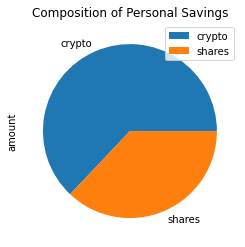

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='amount' ,title="Composition of Personal Savings")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
if emergency_fund < df_savings['amount'].sum():
    print(f'Congratulation! You are exceeding your financial goal')
elif emergency_fund == df_savings['amount'].sum():
    print(f'Congratulation! You are on track of reaching your financial goal.')
elif emergency_fund > df_savings['amount'].sum():
    remaining_savings = (df_savings['amount'].sum())-emergency_fund
    print(f'You are currently missing $ {abs(remaining_savings):0.2f} of reaching your financial goal.')

Congratulation! You are exceeding your financial goal


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen

# Based from Today's latest trading date - get the date 5 years ago
five_yrs_ago_raw = trading_end_date_raw - relativedelta(years=5)
# Define the calendar lookup to get the most recent trading day 5 years ago. 
start_date_five_yrs_ago = five_yrs_ago_raw - datetime.timedelta(days=7)

trading_start_date_raw = max(nyse.valid_days(start_date=start_date_five_yrs_ago, end_date=five_yrs_ago_raw).date)
trading_start_date = pd.Timestamp(trading_start_date_raw, tz=timezone).isoformat()

# Note: We have already initiated the trading_end_date as of latest closing date
print(trading_start_date)
print(trading_end_date)

2016-02-18T00:00:00-05:00
2021-02-18T00:00:00-05:00


In [15]:
# Define middle date to break apart 5 years request of data into 2 different datasets

trading_middle_date_raw = trading_end_date_raw + (trading_start_date_raw - trading_end_date_raw)/2
trading_middle_date_raw_2 = trading_middle_date_raw - timedelta(1)

trading_middle_date = pd.Timestamp(trading_middle_date_raw, tz=timezone).isoformat()
trading_middle_date_2 = pd.Timestamp(trading_middle_date_raw_2, tz=timezone).isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
df_stocks_bonds_hist_1 = alpaca.get_barset(
    tickers,
    timeframe,
    limit = 1000,
    start = trading_start_date,
    end = trading_middle_date_2
).df

df_stocks_bonds_hist_2 = alpaca.get_barset(
    tickers,
    timeframe,
    limit = 1000,
    start = trading_middle_date,
    end = trading_end_date
).df

# Display sample data
df_stocks_bonds_hist = pd.concat([df_stocks_bonds_hist_1, df_stocks_bonds_hist_2], axis='rows', join='inner')
df_stocks_bonds_hist.head()

AGG                                      SPY  \
                             open    high     low   close   volume    open   
time                                                                         
2016-02-18 00:00:00-05:00  109.50  109.81  109.45  109.75  2595248  193.20   
2016-02-19 00:00:00-05:00  109.80  109.85  109.64  109.78  2124710  191.17   
2016-02-22 00:00:00-05:00  109.77  109.88  109.72  109.82  2239411  193.87   
2016-02-23 00:00:00-05:00  109.63  110.00  109.52  109.85  2148002  194.00   
2016-02-24 00:00:00-05:00  110.12  110.32  109.84  109.89  2339276  190.63   

                                                              
                             high     low   close     volume  
time                                                          
2016-02-18 00:00:00-05:00  193.27  191.72  192.04   86202947  
2016-02-19 00:00:00-05:00  192.18  190.45  192.02   79539603  
2016-02-22 00:00:00-05:00  194.95  193.79  194.79   74798121  
2016-02-23 00:00:00-05:00  194.32  192.18  192.37   87929515  
2016-02-24 00:00:00-05:00  193.53  189.32  193.22  119140590

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stocks_bonds_thirty = MCSimulation(
    portfolio_data=df_stocks_bonds_hist,
    weights=[.4, .6],
    num_simulation=500,
    num_trading_days=252*30
)

In [18]:
# Printing the simulation input data
MC_stocks_bonds_thirty.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
time                                                                 
2016-02-18 00:00:00-05:00  109.50  109.81  109.45  109.75  2595248   
2016-02-19 00:00:00-05:00  109.80  109.85  109.64  109.78  2124710   
2016-02-22 00:00:00-05:00  109.77  109.88  109.72  109.82  2239411   
2016-02-23 00:00:00-05:00  109.63  110.00  109.52  109.85  2148002   
2016-02-24 00:00:00-05:00  110.12  110.32  109.84  109.89  2339276   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-02-18 00:00:00-05:00          NaN  193.20  193.27  191.72  192.04   
2016-02-19 00:00:00-05:00     0.000273  191.17  192.18  190.45  192.02   
2016-02-22 00:00:00-05:00     0.000364  193.87  194.95  193.79  194.79   
2016-02-23 00:00:00-05:00     0.000273  194.00  194.32  192.18  192.37   
2016-02-24 00:00:00-05:00     0.000364  190.63  193.53  189.32  193.22   

                                                   
                              volume daily_return  
time                                               
2016-02-18 00:00:00-05:00   86202947          NaN  
2016-02-19 00:00:00-05:00   79539603    -0.000104  
2016-02-22 00:00:00-05:00   74798121     0.014426  
2016-02-23 00:00:00-05:00   87929515    -0.012424  
2016-02-24 00:00:00-05:00  119140590     0.004419

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stocks_bonds_thirty.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006160,0.994610,1.007188,1.006509,0.999261,0.997864,1.008160,0.997533,1.005618,1.001199,...,1.006304,0.998981,1.000050,1.005101,0.998588,0.998938,1.012330,0.998662,1.009815,0.996119
2,1.014562,0.991550,1.014742,1.006165,0.990755,1.007539,0.994011,0.993458,1.010912,0.997567,...,0.996453,1.015540,0.996709,1.006540,0.998577,1.003197,1.014805,1.009269,1.002739,1.008311
3,1.013141,1.006231,1.006591,1.004331,0.994123,1.001342,0.989131,0.995303,1.013378,1.013032,...,1.001365,1.022563,0.987423,1.010349,0.992432,1.001862,1.015017,1.014488,1.008310,1.008186
4,1.004535,1.012307,1.003848,1.004644,0.991476,1.008176,0.976441,0.994024,1.017745,1.004215,...,1.001983,1.029137,0.990283,1.023681,1.001244,0.995808,1.009874,1.020207,1.022240,1.011911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,19.146608,7.855911,26.471760,16.903370,39.566144,21.246591,40.280454,70.386877,39.743561,15.746515,...,34.540616,19.388488,30.645208,32.985572,48.652891,15.245834,38.570403,16.693844,12.169060,30.640567
7557,18.973697,7.882495,26.303613,17.114544,40.144439,21.141622,40.443538,69.928206,39.708342,15.771369,...,34.745215,19.330100,30.336548,33.420070,49.204097,15.145793,39.066066,16.560758,12.209898,30.279155
7558,18.989576,7.874177,26.215701,17.153658,40.239798,21.243860,40.400541,70.271107,39.677194,15.723532,...,34.937793,19.400009,30.085965,33.502638,49.201992,15.347043,38.795751,16.497369,12.249961,30.237764
7559,19.116922,7.887424,26.092830,17.378952,40.348482,21.205177,40.818949,70.582521,39.781644,15.761189,...,34.843576,19.413636,30.280537,33.421775,49.549885,15.257836,38.787525,16.244791,12.274310,30.127832


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

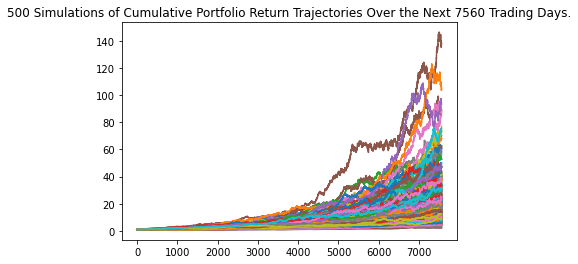

In [20]:
# Plot simulation outcomes
MC_stocks_bonds_thirty.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

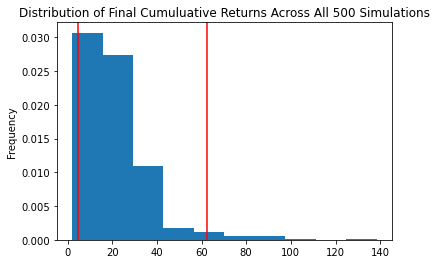

In [21]:
# Plot probability distribution and confidence intervals
MC_stocks_bonds_thirty.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_stocks_bonds_thirty = MC_stocks_bonds_thirty.summarize_cumulative_return()
# Print summary statistics
print(tbl_stocks_bonds_thirty)

count           500.000000
mean             21.454163
std              15.599635
min               2.061353
25%              11.345415
50%              17.505369
75%              26.035802
max             138.366408
95% CI Lower      4.585367
95% CI Upper     62.350680
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl_stocks_bonds_thirty[8]*initial_investment,2)
ci_upper = round(tbl_stocks_bonds_thirty[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $91707.35 and $1247013.6


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl_stocks_bonds_thirty[8]*initial_investment,2)
ci_upper = round(tbl_stocks_bonds_thirty[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $137561.02 and $1870520.4


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_stocks_bonds_five = MCSimulation(
    portfolio_data=df_stocks_bonds_hist,
    weights=[.4, .6],
    num_simulation=500,
    num_trading_days=252*5
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_stocks_bonds_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000194,1.022125,0.988630,1.011318,1.003532,0.998398,1.005766,0.996653,1.003211,0.996409,...,1.001243,1.000240,1.001503,0.993358,1.001340,1.005625,1.006598,1.003568,0.994237,0.993941
2,1.016014,1.022567,0.996545,1.018250,0.995764,1.004302,1.014150,0.993578,1.000975,0.989103,...,1.002647,0.996911,0.999224,0.999384,1.011339,1.008453,1.014474,0.992935,0.994654,0.994470
3,1.019010,1.022511,0.998744,1.022348,0.998732,1.018619,1.008386,0.995580,1.001611,0.990977,...,1.000476,1.021598,1.006075,0.986602,1.008783,1.019013,1.028245,0.998348,1.009580,1.005455
4,1.020798,1.013985,0.989704,1.022384,0.995811,1.011540,0.988793,0.991188,1.005933,0.985782,...,0.998519,1.022349,1.003529,0.989901,1.016573,1.032398,1.039248,1.003576,1.003836,0.992720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.324485,1.370136,1.581710,1.397433,1.877665,1.946163,1.991169,1.902704,1.801118,2.036426,...,1.940703,1.753951,0.969814,1.458258,2.079942,1.641510,1.211705,1.495822,2.200146,2.092224
1257,2.316916,1.361688,1.585504,1.398909,1.889827,1.953904,1.985639,1.896164,1.793891,2.029925,...,1.920321,1.756318,0.964744,1.462107,2.077337,1.663052,1.232910,1.484433,2.219608,2.112046
1258,2.293690,1.360292,1.594705,1.395514,1.885232,1.956487,1.983508,1.916327,1.798578,2.040962,...,1.913165,1.764570,0.977094,1.463399,2.071254,1.654448,1.237632,1.473647,2.238089,2.091791
1259,2.319769,1.354732,1.595928,1.400105,1.909684,1.957723,1.993303,1.927124,1.831201,2.051566,...,1.912095,1.766321,0.978121,1.459699,2.098442,1.674525,1.227530,1.469032,2.232730,2.096355


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

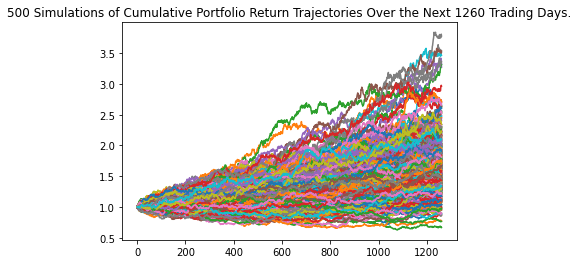

In [27]:
# Plot simulation outcomes
MC_stocks_bonds_five.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

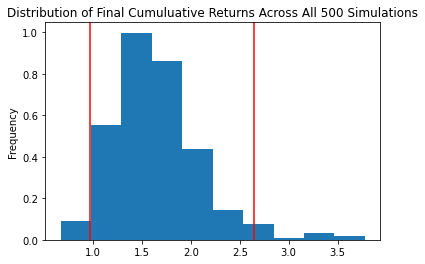

In [28]:
# Plot probability distribution and confidence intervals
MC_stocks_bonds_five.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_stocks_bonds_five = MC_stocks_bonds_five.summarize_cumulative_return()

# Print summary statistics
print(tbl_stocks_bonds_five)

count           500.000000
mean              1.646338
std               0.448600
min               0.669280
25%               1.339427
50%               1.588850
75%               1.873494
max               3.777641
95% CI Lower      0.975474
95% CI Upper      2.647783
Name: 1260, dtype: float64


In [30]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_stocks_bonds_five[8]*initial_investment,2)
ci_upper_five = round(tbl_stocks_bonds_five[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $58528.42 and $158866.97


### Ten Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_stocks_bonds_ten = MCSimulation(
    portfolio_data=df_stocks_bonds_hist,
    weights=[.4, .6],
    num_simulation=500,
    num_trading_days=252*10
)

In [32]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_stocks_bonds_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998184,0.994848,0.996950,1.000567,1.004974,1.013493,0.999154,0.991428,1.002285,1.000180,...,0.993579,1.001599,1.001406,1.007637,1.001539,0.999980,0.995926,0.995340,0.999157,0.994979
2,0.996897,1.000881,1.012846,0.994019,1.003175,1.005455,1.014138,0.994546,0.993610,0.998633,...,0.988720,1.003441,0.991581,1.006134,0.995563,0.997845,0.992078,0.974130,1.008664,0.999823
3,0.994520,1.007429,1.001282,1.001402,1.012831,1.011009,1.006858,0.998933,0.998608,0.987826,...,1.003926,1.004264,0.983447,1.002884,0.994094,1.004004,1.004911,0.979736,0.992170,0.999359
4,0.986159,1.011387,1.000465,0.999719,1.011604,1.008327,1.002592,1.002423,0.994199,0.994258,...,1.006768,0.991021,0.984061,1.005409,1.004038,1.005903,1.026554,0.963204,0.997726,0.993722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.425341,1.934644,2.320547,1.205734,2.661874,3.983766,1.511764,2.763791,1.812023,1.699911,...,1.500887,2.262922,1.832064,3.901516,2.144950,3.344271,3.097406,4.234743,2.345759,2.755876
2517,1.407569,1.936238,2.337335,1.205409,2.660419,3.986948,1.507785,2.740142,1.819075,1.707783,...,1.489532,2.278993,1.818056,3.905800,2.127556,3.347406,3.113376,4.247947,2.355047,2.755392
2518,1.402048,1.946162,2.343358,1.194469,2.690157,3.986635,1.516348,2.755065,1.822785,1.738219,...,1.485540,2.275434,1.818730,3.904844,2.155837,3.386101,3.101497,4.281179,2.355820,2.759331
2519,1.407672,1.935002,2.323205,1.194396,2.687485,3.974489,1.528046,2.742791,1.806081,1.747798,...,1.492777,2.284920,1.803099,3.885468,2.147755,3.399430,3.109585,4.277476,2.360674,2.760290


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

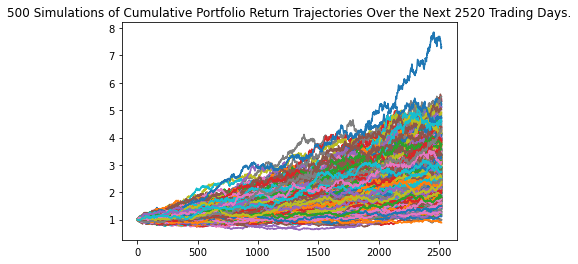

In [33]:
# Plot simulation outcomes
MC_stocks_bonds_ten.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

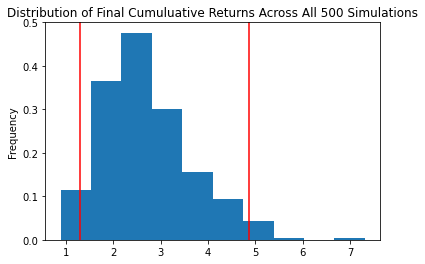

In [34]:
# Plot probability distribution and confidence intervals
MC_stocks_bonds_ten.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_stocks_bonds_ten = MC_stocks_bonds_ten.summarize_cumulative_return()

# Print summary statistics
print(tbl_stocks_bonds_ten)

count           500.000000
mean              2.714804
std               0.930325
min               0.888741
25%               2.063715
50%               2.549410
75%               3.252503
max               7.312283
95% CI Lower      1.291673
95% CI Upper      4.876817
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_stocks_bonds_ten[8]*initial_investment,2)
ci_upper_ten = round(tbl_stocks_bonds_ten[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $77500.41 and $292609.04
